In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt-get install tesseract-ocr-ara

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-ara tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 27 not upgraded.
Need to get 5,495 kB of archives.
After this operation, 17.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-ara all 1:4.00~git30-7274cfa-1 [645 kB]
Fetched 5,495 kB in 0s (11.3 MB/s)
debconf: unable to initialize fr

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
def crop_image(image):
    font = cv2.FONT_HERSHEY_COMPLEX
    borderPoints = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # Find bounding box and extract ROI
    x,y,w,h = cv2.boundingRect(cnts[0])
    cropped_image = image[y:y+h, x:x+w]
    cv2_imshow(cropped_image)
    return cnts[0]

In [ ]:
def draw_contours(image,biggest_contour):
    border_points = []
    peri = cv2.arcLength(biggest_contour, True)
    approx = cv2.approxPolyDP(biggest_contour,0.015*peri,True)
    if len(approx) == 4:
        screenCnt = approx
        n = approx.ravel() 
        i = 0
        for j in n : 
          if(i % 2 == 0): 
              x = n[i] 
              y = n[i + 1] 
              border_points.append([x,y])
          i = i + 1

    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3) 
    return border_points

In [ ]:
def perspectiveTransform(image,border_points):
    a,b,c,d = border_points
    origin_points_dict = {'a': [0,0], 'b': [0,820], 'c': [1280,0], 'd':[1280,820]}
    border_points_dict = {'a': a, 'b': b, 'c': c, 'd':d}
    print(border_points)
    origin_points = dict(sorted(origin_points_dict.items(), key=lambda item: item[1][0] + item[1][1]))
    border_points = dict(sorted(border_points_dict.items(), key=lambda item: item[1][0] + item[1][1]))
    origin_points = list(origin_points.values())
    border_points = list(border_points.values())
    if border_points[1][0] > border_points[1][1] and origin_points[1][0] < origin_points[1][1]:
      temp = [border_points[1][0],border_points[1][1]]
      border_points[1] = border_points[2]
      border_points[2] = temp
    print("_______________")
    print(origin_points)
    print(border_points)
    pts1 = np.float32(border_points)
    pts2 = np.float32(origin_points)
    M = cv2.getPerspectiveTransform(pts1,pts2)
    transformed = cv2.warpPerspective(image,M,(1280,820))
    cv2_imshow(transformed)
    cv2.imwrite('transformed_image.jpg', transformed)
    cv2.waitKey(0)

In [ ]:
def perform_rotation(img, num_rotations):
  if num_rotations == 1:
    image_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  elif num_rotations == 2:
    image_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_CLOCKWISE)
  elif num_rotations == 3:
    image_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_CLOCKWISE)
    image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_CLOCKWISE)
  return image_rotated

In [ ]:
def getAveragePixQuarter(image):
  quarter_top_left = image[:len(image)//2,:len(image[0])//2] 
  quarter_bottom_left = image[len(image)//2:,:len(image[0])//2] 
  quarter_top_right = image[:len(image)//2,len(image[0])//2:] 
  quarter_bottom_right = image[len(image)//2:,len(image[0])//2:]
  quarters = {'quarter_top_left': np.average(quarter_top_left), 'quarter_bottom_left': np.average(quarter_bottom_left), 
                       'quarter_top_right': np.average(quarter_top_right), 'quarter_bottom_right': np.average(quarter_bottom_right)}
  sorted_quarters_by_avg = sorted(quarters.items(), key=lambda x:x[1])
  if sorted_quarters_by_avg[-1][0] != "quarter_top_left":
    if sorted_quarters_by_avg[-1][0] == "quarter_bottom_left":
      image = perform_rotation(image, 1)
    elif sorted_quarters_by_avg[-1][0] == "quarter_bottom_right":
      image = perform_rotation(image, 2)
    elif sorted_quarters_by_avg[-1][0] == "quarter_top_right":
      image = perform_rotation(image, 3)
  image_adjusted = cv2.resize(image, (1280, 820))
  return image_adjusted

In [ ]:
def remove_white_background(img):
  img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0]
  return img

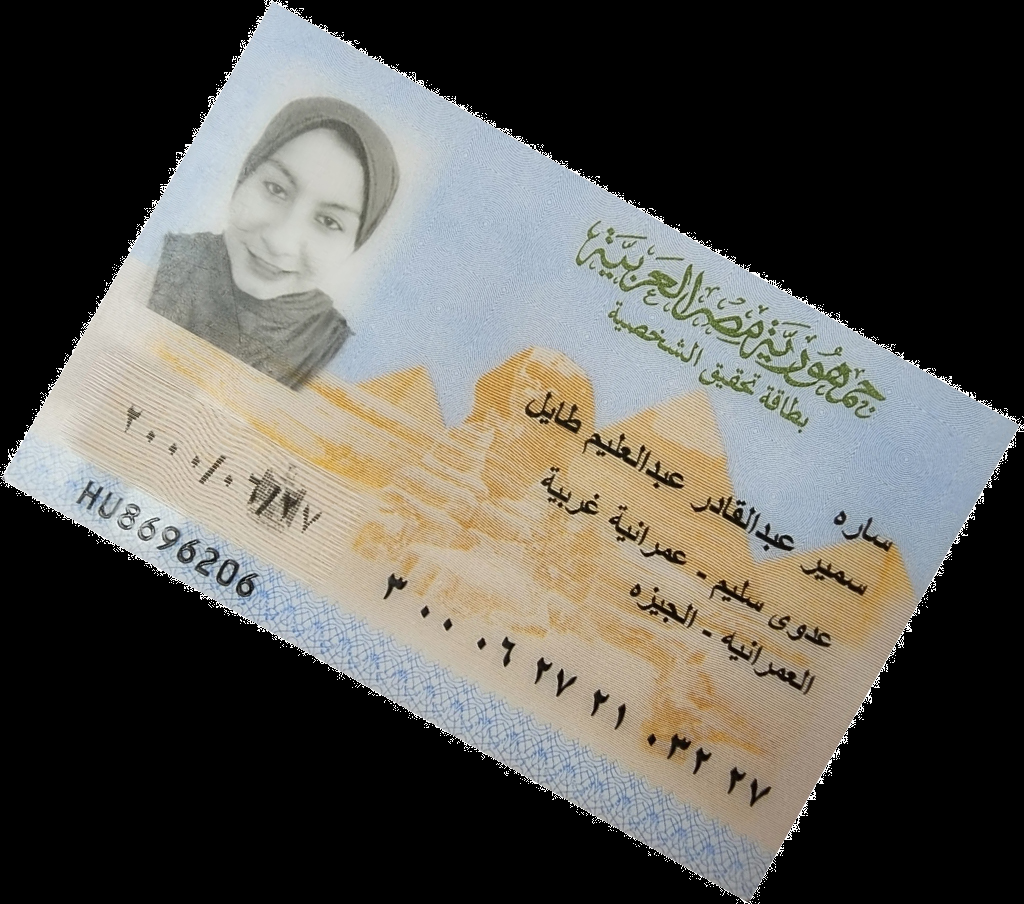

[[768, 88], [509, 574], [1255, 991], [1525, 508]]
_______________
[[0, 0], [0, 820], [1280, 0], [1280, 820]]
[[768, 88], [509, 574], [1525, 508], [1255, 991]]


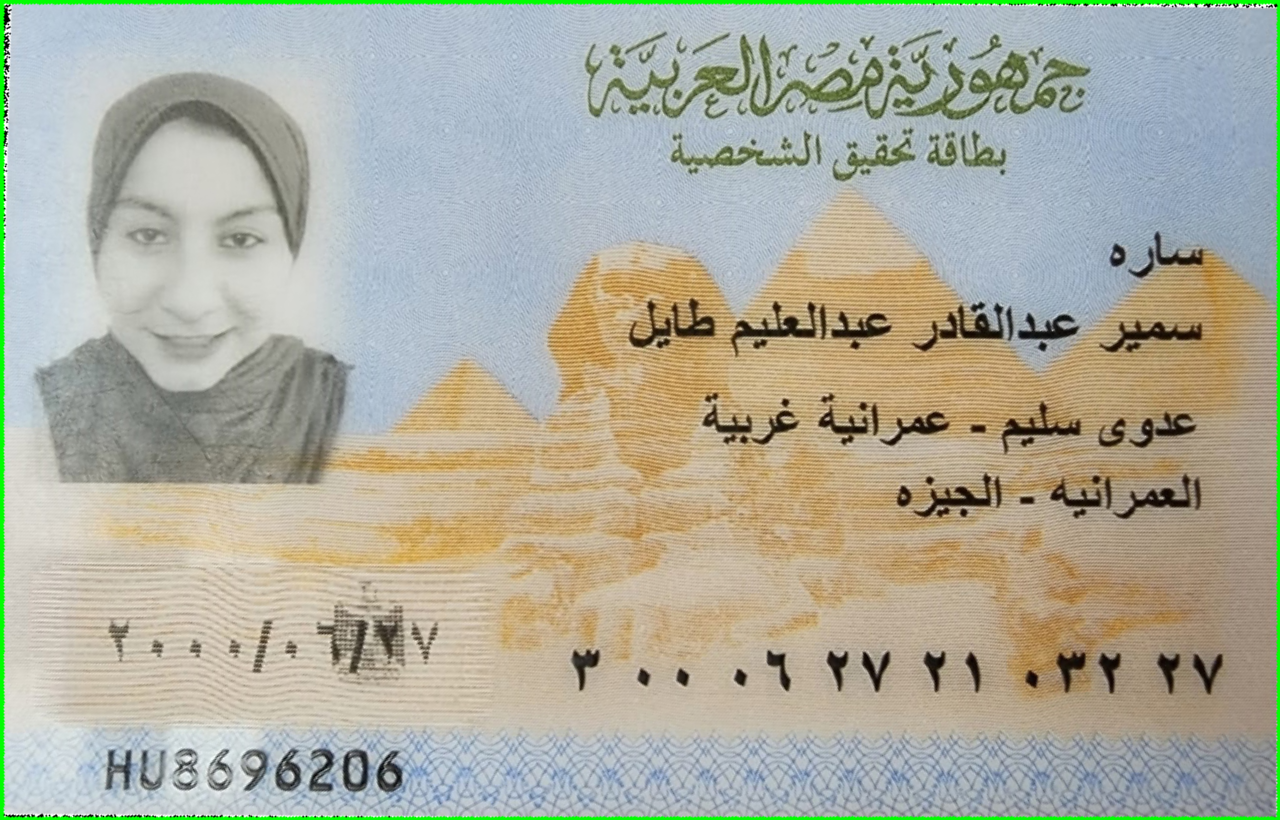

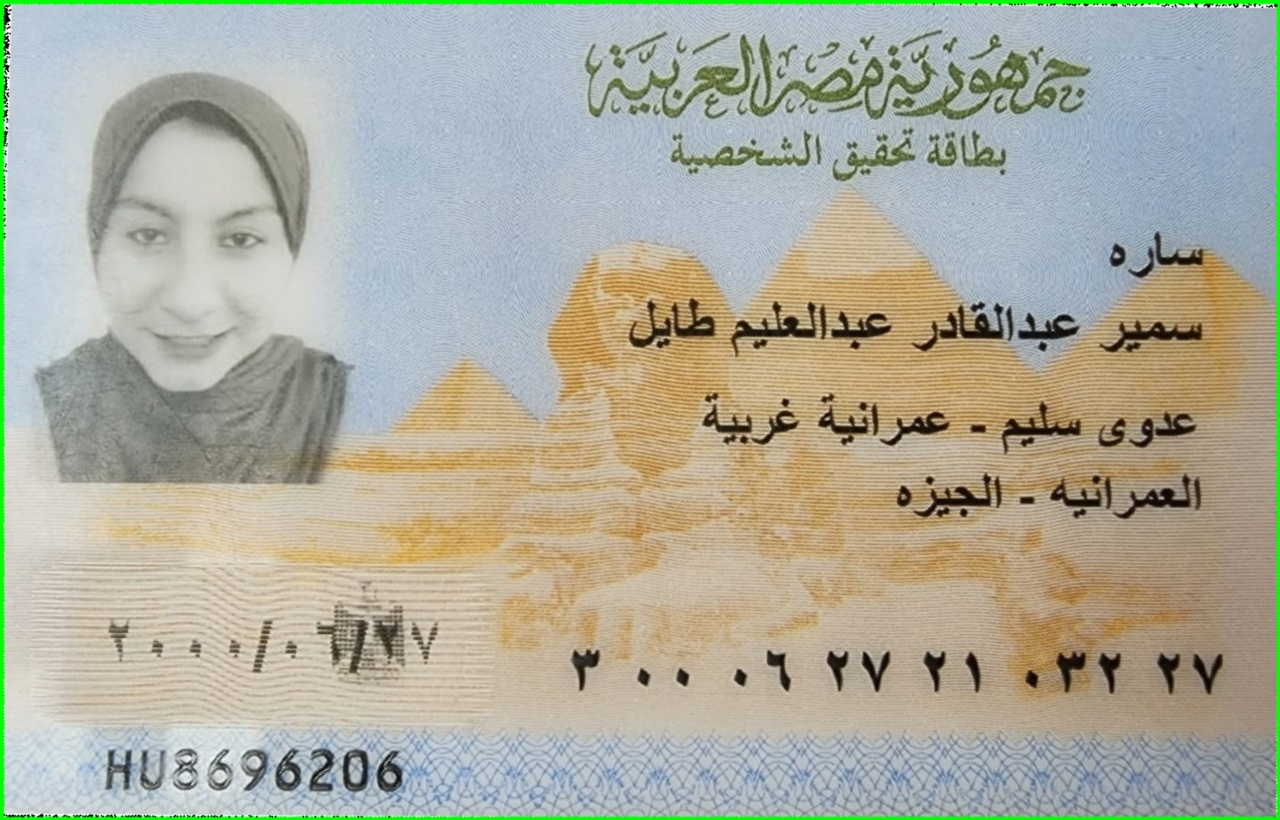

In [ ]:
img_younan = cv2.imread('/content/white board4.jpg')

img_younan = remove_white_background(img_younan)
biggest_contour = crop_image(img_younan)
borders = draw_contours(img_younan, biggest_contour)
perspectiveTransform(img_younan, borders)
transformed = cv2.imread('transformed_image.jpg')
adjusted_image = getAveragePixQuarter(transformed)
cv2.imwrite('adjusted_image.jpg', adjusted_image)
cv2_imshow(adjusted_image)

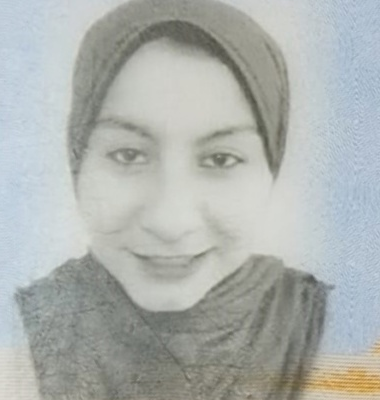

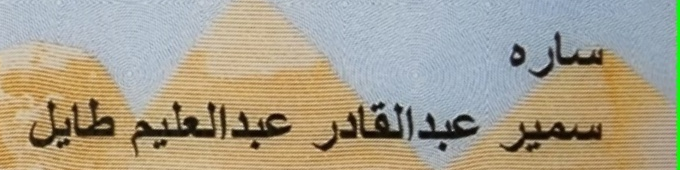

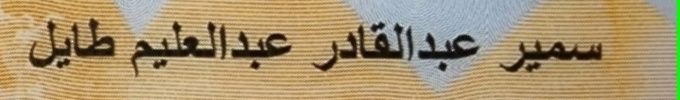

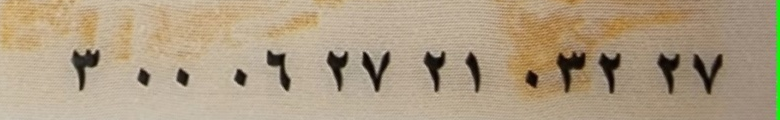

In [ ]:
img_2 = cv2.imread('/content/adjusted_image.jpg')
# Cropping an image
cropped_image_photo = img_2[80:480, 20:400]
cropped_image_fitst_name = img_2[200:370, 600:]
cropped_image_last_name = img_2[280:380, 600:]
cropped_image_id = img_2[600:-100, 500:]
# Display cropped image
cv2_imshow(cropped_image_photo)
cv2_imshow(cropped_image_fitst_name)
cv2_imshow(cropped_image_last_name)
cv2_imshow(cropped_image_id)

In [ ]:
import numpy as np
import os  

def remove_noise(image,median):
    return cv2.medianBlur(image,median)
def dilate(image, dialation):
    kernel = np.ones((dialation,dialation),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

In [ ]:
import pytesseract

def preprocess(image, median, dialation):
  grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_2 = remove_noise(grayImage, median)
  # img_2 = increase_contrast(img_2)
  img_2 = dilate(img_2, dialation)
  (thresh, blackAndWhiteImage) = cv2.threshold(img_2, 100, 255, cv2.THRESH_BINARY)
  cv2_imshow(blackAndWhiteImage)
  return blackAndWhiteImage

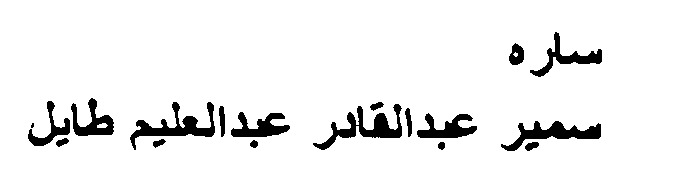

ساره
سمير عبدالقادر عبدالعليم طا
يم طايل



In [ ]:
firstName = preprocess(cropped_image_fitst_name, 5, 1)

arabic_text=pytesseract.image_to_string(firstName, lang='ara',config= ".")

print(arabic_text)

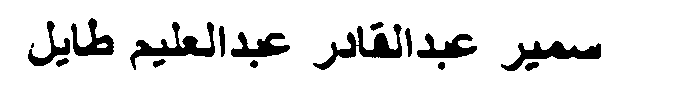

سمير عبدالقادر عبدالعليم طايل



In [ ]:
secondName = preprocess(cropped_image_last_name, 5, 1)

arabic_text=pytesseract.image_to_string(secondName, lang='ara',config= ".")

print(arabic_text)

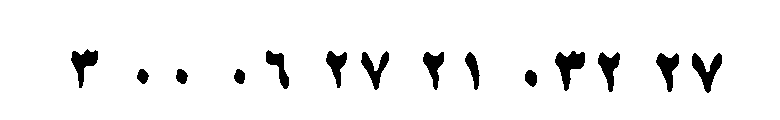

 
 ٧ ٢ ٢ ٣ ٠ ١ ٢ ٧ ٢ ٦ ٠ ٠ ٠ ٣ 

In [ ]:
import shutil

shutil.copyfile("/content/drive/MyDrive/Asses/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")
id = preprocess(cropped_image_id, 5, 1)

arabic_text=pytesseract.image_to_string(id , lang='arabic_numbers',config= ".")
for i in arabic_text[::-1]:
  if i != ' ':
    print(i, end=" ")

## Very Important Cells to operate once at some point

In [ ]:
# import os
# import shutil

# os.rename("/content/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")
# os.replace("/content/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")
# shutil.move("/content/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")